画像切り抜き処理を追加  

画像加工

Resnet50ベースのファインチューニング

In [6]:
# パッケージのimport
import re
import glob
import os.path as osp
import os
import pandas as pd
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms

In [7]:
# from google.colab import drive
# drive.mount('./gdrive', force_remount=True)

In [8]:
! pip3 install signate

     |████████████████████████████████| 138 kB 11.3 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=d088c742ed606807ad28205581e5bc061d1f3a8abb89c649751cc18dfc0b8260
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [9]:
! signate token --email=yakiniku0831@gmail.com --password=md2yMqU8X9JJAq2


The API Token has been downloaded successfully.


In [10]:
! signate list

  competitionId  title                                                                                  closing     prize            submitters
---------------  -------------------------------------------------------------------------------------  ----------  -------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                                   -                                  5175
             24  【練習問題】お弁当の需要予測                                                           -                                  6345
             27  【練習問題】Jリーグの観客動員数予測                                                    -                                  1433
            100  【練習問題】手書き文字認識                                                             -           Knowledge               174
            102  【練習問題】タイタニックの生存予測                                                     -           Knowledge              1064
            103  【練習問題】音楽ラベリング                                         

In [11]:
! signate files --competition-id=499

  fileId  name                                           title                                                size  updated_at
--------  ---------------------------------------------  ----------------------------------------------  ---------  -------------------
    2219  PBL02_h_exercise4_question.pdf                 PBL02_不良個所自動検出_h.演習④設問                1417656  2021-08-19 15:22:04
    2220  PBL02_i_exercise4_supplementary-documents.pdf  PBL02_不良個所自動検出_i.演習④ガイドコンテンツ     470147  2021-08-19 15:22:07
    2138  train.zip                                      学習用画像データ                                183977509  2021-08-19 15:22:07
    2139  test.zip                                       評価用画像データ                                151304061  2021-08-19 15:22:07
    2140  train_master.tsv                               学習用画像データとラベルIDの対応表                   5221  2021-08-19 15:22:07
    2141  sample_submit.tsv                              応募用サンプルファイル                                100  2021-08-19 15:

In [12]:
! signate download --competition-id=499

sample_submit.tsv

requirements.txt

train_master.tsv

PBL02_sample_code.ipynb

PBL02_i_exercise4_supplementary-documents.pdf

PBL02_h_exercise4_question.pdf

test.zip

train.zip


Download completed.


In [13]:
print(torch.cuda.is_available())

True


In [484]:
#  !rm -r ./Data

In [485]:
!mkdir -p ./Data/kiban/
!unzip -o ./train.zip -d ./Data/kiban/
!unzip -o ./test.zip -d ./Data/kiban/
!cp ./train_master.tsv ./Data/kiban/

Archive:  ./train.zip
   creating: ./Data/kiban/train/
   creating: ./Data/kiban/train/bridge/
  inflating: ./Data/kiban/train/bridge/bridge_000.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_001.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_002.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_003.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_004.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_005.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_006.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_007.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_008.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_009.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_010.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_011.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_012.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_013.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_014.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_015.

In [486]:
# validation用のフォルダを作成
!mkdir -p ./Data/kiban/valid/
!mkdir -p ./Data/kiban/valid/regular/
!mkdir -p ./Data/kiban/valid/potato/
!mkdir -p ./Data/kiban/valid/horn/
!mkdir -p ./Data/kiban/valid/bridge/

resizeした画像を保存

In [487]:
import cv2
from google.colab.patches import cv2_imshow

In [488]:
# img = cv2.imread(train_dir + '/regular/regular_000.jpeg')
# dst = cv2.resize(img, dsize=(224, 224))

# print(f"{img.shape} -> {dst.shape}")
# # plt.imshow(dst)

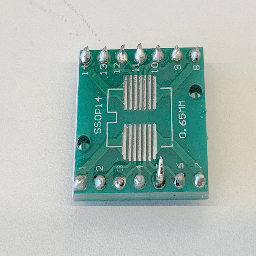

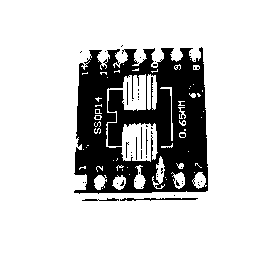

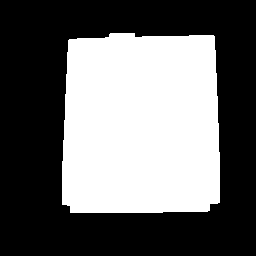

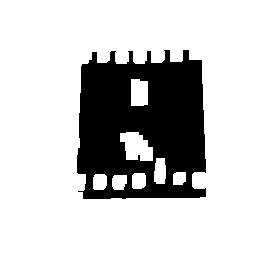

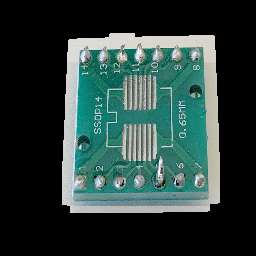

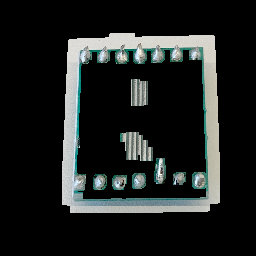

In [489]:
# 2値画像はVGG16だめらしい
# https://discuss.pytorch.org/t/runtimeerror-given-groups-1-weight-of-size-64-3-7-7-expected-input-3-1-224-224-to-have-3-channels-but-got-1-channels-instead/30153/3
# これはどう？
# 色検出でマスク画像作成(白っぽい色をぬかす)、モルフォジー変換でハンダ部分拡張


image_path = './Data/kiban/train/horn/horn_023.jpeg'
img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(256, 256))

img_g = cv2.imread(image_path,0)
img_g = cv2.resize(img_g, dsize=(256, 256))

gamma = 2 # 明るくなる
gamma_cvt = np.zeros((256,1), dtype=np.uint8) # 256行1列の0ベクトル

for i in range(256):
  gamma_cvt[i][0] = 255 * (float(i)/255) ** (1.0 / gamma)

img = cv2.LUT(img, gamma_cvt)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# 緑色を抜き出す, 下限値、上限値を指定する
# hsv空間は、hは通常のhueの半分の値（openCV上では）
# 下の例だと、hue20-50が抽出される（svは100/255%）
lower_white = np.array([0, 0, 100])
upper_white = np.array([180,90,255])

lower_green = np.array([30, 40, 0])
upper_green = np.array([90,255,255])

# マスク画像作成(緑色ぽい色の部分が2値化画像で保存される)
img_mask_white = cv2.inRange(hsv, lower_white, upper_white)
img_mask_green = cv2.inRange(hsv, lower_green, upper_green)

# 逆マスクも作ってみる（白黒反転）
img_mask_white_rev = cv2.bitwise_not(img_mask_white)
img_mask_green_rev = cv2.bitwise_not(img_mask_green)

# モルフォジー変換で白拡張
kernel = np.ones((5,5), dtype=np.uint8) # 自分の画素から探す領域
# img_e = cv2.erode(img_mask_rev, kernel) # 収縮
img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張


img_mask_green_rev = cv2.erode(img_mask_green_rev, kernel) # 収縮
img_mask_green_rev = cv2.dilate(img_mask_green_rev, kernel) # 膨張
img_mask_green_rev = cv2.dilate(img_mask_green_rev, kernel) # 膨張


# 2値画像の論理積を出して、マスク部分だけを抽出
dst = cv2.bitwise_and(img, img, mask = img_mask_white_rev)
dst_green = cv2.bitwise_and(dst, dst, mask = img_mask_green_rev)

gamma = 1 # 明るくなる
gamma_cvt = np.zeros((256,1), dtype=np.uint8) # 256行1列の0ベクトル

for i in range(256):
  gamma_cvt[i][0] = 255 * (float(i)/255) ** (1.0 / gamma)

img_gamma = cv2.LUT(dst_green, gamma_cvt)


cv2_imshow(img)
cv2_imshow(img_mask_white)
cv2_imshow(img_mask_white_rev)
cv2_imshow(img_mask_green_rev)
cv2_imshow(dst)
cv2_imshow(dst_green)
# cv2_imshow(img_gamma)

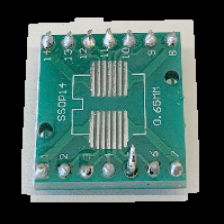

In [490]:
retval = cv2.boundingRect(img_mask_white_rev) 

top = int(retval[1] * 0.5)
bottom = int((retval[1] + retval[3]) * 1.1)
left = int(retval[0] * 0.7)
right = int((retval[0] + retval[2]) * 1.1)

img_cut = dst[top : bottom , left : right]
img_cut = cv2.resize(img_cut, dsize=(224, 224))

# img_bi = cv2.bilateralFilter(dst, 20, 30, 30)

# threshold = 80

# retにはthreshold値, img_thには画像が入る
# ret, img_th = cv2.threshold(img_bi, threshold, 255, cv2.THRESH_BINARY)


cv2_imshow(img_cut )
# cv2_imshow(dst)

In [491]:
# # 2値画像、resizeと切り抜きの関数
# def image_resize_cut(image_path):
#   img = cv2.imread(image_path)
#   img = cv2.resize(img, dsize=(224, 224))

#   img_g = cv2.imread(image_path,0)
#   img_g = cv2.resize(img_g, dsize=(224, 224))

#   hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#   # 緑色を抜き出す, 下限値、上限値を指定する
#   # hsv空間は、hは通常のhueの半分の値（openCV上では）
#   # 下の例だと、hue20-50が抽出される（svは100/255%）
#   lower = np.array([30, 50, 50])
#   upper = np.array([90,255,255])
#   # マスク画像作成(緑色ぽい色の部分が2値化画像で保存される)
#   img_mask = cv2.inRange(hsv, lower, upper)

#   retval = cv2.boundingRect(img_mask) 
  
#   top = int(retval[1] * 0.5)
#   bottom = int((retval[1] + retval[3]) * 1.1)
#   left = int(retval[0] * 0.7)
#   right = int((retval[0] + retval[2]) * 1.1)

#   img_cut = img[top : bottom , left : right]
#   dst = cv2.resize(img_cut, dsize=(224, 224))

#   img_bi = cv2.bilateralFilter(dst, 20, 30, 30)

#   # threshold = 70

#   # # retにはthreshold値, img_thには画像が入る
#   # ret, img_th = cv2.threshold(img_bi, threshold, 255, cv2.THRESH_BINARY)
  


#   # dst = cv2.resize(, dsize=(224, 224))
#   print(f"{img.shape} -> {dst.shape}")
#   cv2.imwrite(image_path, img_bi)

In [492]:
# モルフォジー変換で基板部分以外黒塗り
def image_resize_cut(image_path):
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(448, 448))

  img_g = cv2.imread(image_path,0)
  img_g = cv2.resize(img_g, dsize=(448, 448))

  
  gamma = 1.8 # 明るくなる
  gamma_cvt = np.zeros((256,1), dtype=np.uint8) # 256行1列の0ベクトル

  for i in range(256):
    gamma_cvt[i][0] = 255 * (float(i)/255) ** (1.0 / gamma)

  img = cv2.LUT(img, gamma_cvt)

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  # 緑色を抜き出す, 下限値、上限値を指定する
  # hsv空間は、hは通常のhueの半分の値（openCV上では）
  # 下の例だと、hue20-50が抽出される（svは100/255%）
  lower_white = np.array([0, 0, 100])
  upper_white = np.array([180,90,255])

  lower_green = np.array([30, 40, 0])
  upper_green = np.array([90,255,255])

  # マスク画像作成(緑色ぽい色の部分が2値化画像で保存される)
  img_mask_white = cv2.inRange(hsv, lower_white, upper_white)
  img_mask_green = cv2.inRange(hsv, lower_green, upper_green)

  # 逆マスクも作ってみる（白黒反転）
  img_mask_white_rev = cv2.bitwise_not(img_mask_white)
  img_mask_green_rev = cv2.bitwise_not(img_mask_green)

  # モルフォジー変換で白拡張
  kernel = np.ones((5,5), dtype=np.uint8) # 自分の画素から探す領域
  # img_e = cv2.erode(img_mask_rev, kernel) # 収縮
  img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
  img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
  img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
  img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
  img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張
  img_mask_white_rev = cv2.dilate(img_mask_white_rev, kernel) # 膨張


  img_mask_green_rev = cv2.erode(img_mask_green_rev, kernel) # 収縮
  img_mask_green_rev = cv2.dilate(img_mask_green_rev, kernel) # 膨張
  img_mask_green_rev = cv2.dilate(img_mask_green_rev, kernel) # 膨張


  # 2値画像の論理積を出して、マスク部分だけを抽出
  dst = cv2.bitwise_and(img, img, mask = img_mask_white_rev)
  # dst_green = cv2.bitwise_and(dst, dst, mask = img_mask_green_rev)
  
  retval = cv2.boundingRect(img_mask_white_rev) 

  top = int(retval[1] * 0.5)
  bottom = int((retval[1] + retval[3]) * 1.1)
  left = int(retval[0] * 0.7)
  right = int((retval[0] + retval[2]) * 1.1)

  img_cut = dst[top : bottom , left : right]
  img_cut = cv2.resize(img_cut, dsize=(256, 256))

  # dst = cv2.resize(, dsize=(224, 224))
  print(f"{img.shape} -> {img_cut.shape}")
  cv2.imwrite(image_path, img_cut)

In [493]:
# image_resize_cut(image_path)

In [494]:
path1 = glob.glob('./Data/kiban/*/*/*.jpeg')
_path2 = glob.glob('./Data/kiban/*/*.jpeg')

path1.extend(_path2)

In [495]:
path1

['./Data/kiban/train/bridge/bridge_010.jpeg',
 './Data/kiban/train/bridge/bridge_001.jpeg',
 './Data/kiban/train/bridge/bridge_025.jpeg',
 './Data/kiban/train/bridge/bridge_023.jpeg',
 './Data/kiban/train/bridge/bridge_020.jpeg',
 './Data/kiban/train/bridge/bridge_017.jpeg',
 './Data/kiban/train/bridge/bridge_012.jpeg',
 './Data/kiban/train/bridge/bridge_028.jpeg',
 './Data/kiban/train/bridge/bridge_015.jpeg',
 './Data/kiban/train/bridge/bridge_016.jpeg',
 './Data/kiban/train/bridge/bridge_011.jpeg',
 './Data/kiban/train/bridge/bridge_002.jpeg',
 './Data/kiban/train/bridge/bridge_018.jpeg',
 './Data/kiban/train/bridge/bridge_008.jpeg',
 './Data/kiban/train/bridge/bridge_003.jpeg',
 './Data/kiban/train/bridge/bridge_021.jpeg',
 './Data/kiban/train/bridge/bridge_019.jpeg',
 './Data/kiban/train/bridge/bridge_000.jpeg',
 './Data/kiban/train/bridge/bridge_009.jpeg',
 './Data/kiban/train/bridge/bridge_014.jpeg',
 './Data/kiban/train/bridge/bridge_005.jpeg',
 './Data/kiban/train/bridge/bridge

In [496]:
for i, path in tqdm(enumerate(path1)):
  # print(path)
  image_resize_cut(path)

2it [00:00,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


3it [00:00,  4.91it/s]

(448, 448, 3) -> (256, 256, 3)


4it [00:00,  4.76it/s]

(448, 448, 3) -> (256, 256, 3)


5it [00:01,  4.71it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


8it [00:01,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


10it [00:02,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


11it [00:02,  5.06it/s]

(448, 448, 3) -> (256, 256, 3)


12it [00:02,  4.90it/s]

(448, 448, 3) -> (256, 256, 3)


13it [00:02,  4.87it/s]

(448, 448, 3) -> (256, 256, 3)


15it [00:03,  5.02it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


16it [00:03,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


18it [00:03,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


21it [00:04,  5.07it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


23it [00:04,  5.03it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


24it [00:04,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)


26it [00:05,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


28it [00:05,  5.25it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


30it [00:05,  5.25it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


32it [00:06,  5.24it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


33it [00:06,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)


35it [00:06,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


37it [00:07,  5.08it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


39it [00:07,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


41it [00:08,  5.19it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


43it [00:08,  5.19it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


45it [00:08,  5.13it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


46it [00:09,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)


47it [00:09,  5.07it/s]

(448, 448, 3) -> (256, 256, 3)


48it [00:09,  4.99it/s]

(448, 448, 3) -> (256, 256, 3)


49it [00:09,  4.89it/s]

(448, 448, 3) -> (256, 256, 3)


51it [00:10,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


53it [00:10,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


54it [00:10,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


57it [00:11,  5.08it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


58it [00:11,  5.18it/s]

(448, 448, 3) -> (256, 256, 3)


60it [00:11,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


61it [00:12,  5.15it/s]

(448, 448, 3) -> (256, 256, 3)


62it [00:12,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)


63it [00:12,  4.96it/s]

(448, 448, 3) -> (256, 256, 3)


64it [00:12,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)


66it [00:13,  5.02it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


68it [00:13,  5.06it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


70it [00:13,  5.15it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


71it [00:14,  5.18it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


74it [00:14,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


76it [00:15,  5.23it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


77it [00:15,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)


78it [00:15,  4.90it/s]

(448, 448, 3) -> (256, 256, 3)


80it [00:15,  4.91it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


82it [00:16,  5.14it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


84it [00:16,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


86it [00:17,  5.21it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


88it [00:17,  5.24it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


90it [00:17,  5.27it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


91it [00:17,  5.25it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


93it [00:18,  5.16it/s]

(448, 448, 3) -> (256, 256, 3)


95it [00:18,  5.05it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


97it [00:19,  5.05it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


99it [00:19,  5.14it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


101it [00:19,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


103it [00:20,  5.23it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


105it [00:20,  5.38it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


107it [00:21,  5.24it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


108it [00:21,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)


110it [00:21,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


112it [00:22,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


114it [00:22,  5.22it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


116it [00:22,  5.19it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


118it [00:23,  5.13it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


120it [00:23,  5.14it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


121it [00:23,  5.05it/s]

(448, 448, 3) -> (256, 256, 3)


122it [00:24,  4.94it/s]

(448, 448, 3) -> (256, 256, 3)


124it [00:24,  4.78it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


126it [00:24,  4.87it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


128it [00:25,  5.17it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


130it [00:25,  5.23it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


132it [00:26,  5.21it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


134it [00:26,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


136it [00:26,  5.30it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


137it [00:26,  5.18it/s]

(448, 448, 3) -> (256, 256, 3)


139it [00:27,  5.05it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


141it [00:27,  5.19it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


143it [00:28,  5.21it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


145it [00:28,  5.23it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


147it [00:28,  5.26it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


149it [00:29,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


150it [00:29,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


153it [00:30,  5.02it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


154it [00:30,  4.94it/s]

(448, 448, 3) -> (256, 256, 3)


156it [00:30,  5.08it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


157it [00:30,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)


159it [00:31,  4.95it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


161it [00:31,  5.06it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


163it [00:32,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


165it [00:32,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


167it [00:32,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


168it [00:33,  4.99it/s]

(448, 448, 3) -> (256, 256, 3)


170it [00:33,  4.94it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


172it [00:33,  5.14it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


174it [00:34,  5.19it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


176it [00:34,  5.29it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


177it [00:34,  5.30it/s]

(448, 448, 3) -> (256, 256, 3)


179it [00:35,  5.21it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


181it [00:35,  5.30it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


182it [00:35,  5.23it/s]

(448, 448, 3) -> (256, 256, 3)


183it [00:36,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)


185it [00:36,  5.02it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


187it [00:36,  5.17it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


188it [00:36,  5.18it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


191it [00:37,  5.24it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


193it [00:37,  5.25it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


195it [00:38,  5.26it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


196it [00:38,  5.25it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


198it [00:38,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)


200it [00:39,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


201it [00:39,  5.06it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


204it [00:40,  5.14it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


206it [00:40,  5.21it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


207it [00:40,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)


208it [00:40,  5.00it/s]

(448, 448, 3) -> (256, 256, 3)


209it [00:41,  4.86it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


212it [00:41,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


213it [00:41,  4.92it/s]

(448, 448, 3) -> (256, 256, 3)


214it [00:42,  4.85it/s]

(448, 448, 3) -> (256, 256, 3)


216it [00:42,  4.89it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


218it [00:42,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


220it [00:43,  5.17it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


222it [00:43,  5.15it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


224it [00:44,  5.27it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


226it [00:44,  5.17it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


227it [00:44,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)


229it [00:45,  4.92it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


231it [00:45,  5.05it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


233it [00:45,  5.28it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


234it [00:46,  5.26it/s]

(448, 448, 3) -> (256, 256, 3)


236it [00:46,  5.22it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


238it [00:46,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


240it [00:47,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


242it [00:47,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


243it [00:47,  4.99it/s]

(448, 448, 3) -> (256, 256, 3)


245it [00:48,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


247it [00:48,  4.96it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


249it [00:49,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


251it [00:49,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


253it [00:49,  5.24it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


255it [00:50,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


257it [00:50,  5.13it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


258it [00:50,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)


260it [00:51,  5.03it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


262it [00:51,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


264it [00:51,  5.15it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


266it [00:52,  5.26it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


268it [00:52,  5.32it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


270it [00:53,  5.32it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


271it [00:53,  5.36it/s]

(448, 448, 3) -> (256, 256, 3)


273it [00:53,  5.13it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


274it [00:53,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)


276it [00:54,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


278it [00:54,  5.16it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


280it [00:55,  5.26it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


282it [00:55,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


284it [00:55,  5.22it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


286it [00:56,  5.27it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


287it [00:56,  5.23it/s]

(448, 448, 3) -> (256, 256, 3)


288it [00:56,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)


289it [00:56,  4.92it/s]

(448, 448, 3) -> (256, 256, 3)


291it [00:57,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


293it [00:57,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


294it [00:57,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


296it [00:58,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)


298it [00:58,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


299it [00:58,  5.16it/s]

(448, 448, 3) -> (256, 256, 3)


301it [00:59,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


302it [00:59,  4.81it/s]

(448, 448, 3) -> (256, 256, 3)


303it [00:59,  4.58it/s]

(448, 448, 3) -> (256, 256, 3)


305it [01:00,  4.84it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


307it [01:00,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


309it [01:00,  5.21it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


311it [01:01,  5.24it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


313it [01:01,  5.22it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


314it [01:01,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)


315it [01:01,  5.00it/s]

(448, 448, 3) -> (256, 256, 3)


317it [01:02,  4.95it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


318it [01:02,  4.90it/s]

(448, 448, 3) -> (256, 256, 3)


319it [01:02,  4.86it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


321it [01:03,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)


323it [01:03,  5.17it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


325it [01:03,  5.39it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


326it [01:04,  5.28it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


328it [01:04,  5.22it/s]

(448, 448, 3) -> (256, 256, 3)


330it [01:04,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


331it [01:05,  5.13it/s]

(448, 448, 3) -> (256, 256, 3)


332it [01:05,  5.06it/s]

(448, 448, 3) -> (256, 256, 3)


333it [01:05,  4.94it/s]

(448, 448, 3) -> (256, 256, 3)


335it [01:05,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


337it [01:06,  5.16it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


339it [01:06,  5.20it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


340it [01:06,  5.22it/s]

(448, 448, 3) -> (256, 256, 3)


342it [01:07,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


343it [01:07,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


345it [01:07,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)


346it [01:08,  4.82it/s]

(448, 448, 3) -> (256, 256, 3)


347it [01:08,  4.80it/s]

(448, 448, 3) -> (256, 256, 3)


349it [01:08,  4.86it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


351it [01:09,  5.06it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


353it [01:09,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


355it [01:09,  5.19it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


357it [01:10,  5.26it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


359it [01:10,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


361it [01:11,  5.18it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


362it [01:11,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)


364it [01:11,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


365it [01:11,  5.00it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


367it [01:12,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)


369it [01:12,  5.05it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


371it [01:13,  5.16it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


372it [01:13,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)


374it [01:13,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


375it [01:13,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)


376it [01:14,  4.92it/s]

(448, 448, 3) -> (256, 256, 3)


377it [01:14,  4.70it/s]

(448, 448, 3) -> (256, 256, 3)


378it [01:14,  4.74it/s]

(448, 448, 3) -> (256, 256, 3)


379it [01:14,  4.67it/s]

(448, 448, 3) -> (256, 256, 3)


381it [01:15,  4.85it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


383it [01:15,  4.84it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


385it [01:15,  5.02it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


387it [01:16,  5.12it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


389it [01:16,  5.07it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


391it [01:17,  4.98it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


393it [01:17,  5.07it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


395it [01:17,  5.15it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


397it [01:18,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


399it [01:18,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


400it [01:18,  5.14it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


403it [01:19,  5.07it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


404it [01:19,  5.03it/s]

(448, 448, 3) -> (256, 256, 3)


405it [01:19,  4.88it/s]

(448, 448, 3) -> (256, 256, 3)


406it [01:20,  4.71it/s]

(448, 448, 3) -> (256, 256, 3)


408it [01:20,  4.75it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


409it [01:20,  4.89it/s]

(448, 448, 3) -> (256, 256, 3)


411it [01:21,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


413it [01:21,  4.95it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


415it [01:22,  4.95it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


417it [01:22,  5.14it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


419it [01:22,  5.15it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


420it [01:22,  5.00it/s]

(448, 448, 3) -> (256, 256, 3)


422it [01:23,  4.92it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


423it [01:23,  4.89it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


425it [01:23,  5.07it/s]

(448, 448, 3) -> (256, 256, 3)


426it [01:24,  4.85it/s]

(448, 448, 3) -> (256, 256, 3)


427it [01:24,  4.64it/s]

(448, 448, 3) -> (256, 256, 3)


428it [01:24,  4.59it/s]

(448, 448, 3) -> (256, 256, 3)


429it [01:24,  4.57it/s]

(448, 448, 3) -> (256, 256, 3)


431it [01:25,  4.79it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


433it [01:25,  4.95it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


434it [01:25,  4.89it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


437it [01:26,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


438it [01:26,  5.03it/s]

(448, 448, 3) -> (256, 256, 3)


440it [01:27,  5.00it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


442it [01:27,  5.08it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


443it [01:27,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)


445it [01:28,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


446it [01:28,  5.11it/s]

(448, 448, 3) -> (256, 256, 3)


447it [01:28,  4.99it/s]

(448, 448, 3) -> (256, 256, 3)


448it [01:28,  4.78it/s]

(448, 448, 3) -> (256, 256, 3)


449it [01:28,  4.69it/s]

(448, 448, 3) -> (256, 256, 3)


451it [01:29,  4.77it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


453it [01:29,  5.00it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


454it [01:29,  5.05it/s]

(448, 448, 3) -> (256, 256, 3)


456it [01:30,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


457it [01:30,  5.00it/s]

(448, 448, 3) -> (256, 256, 3)


458it [01:30,  4.90it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


461it [01:31,  4.94it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


462it [01:31,  4.94it/s]

(448, 448, 3) -> (256, 256, 3)


463it [01:31,  4.80it/s]

(448, 448, 3) -> (256, 256, 3)


464it [01:32,  4.72it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


466it [01:32,  4.87it/s]

(448, 448, 3) -> (256, 256, 3)


468it [01:32,  4.92it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


470it [01:33,  5.07it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


471it [01:33,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)


473it [01:33,  5.06it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


474it [01:34,  4.87it/s]

(448, 448, 3) -> (256, 256, 3)


475it [01:34,  4.89it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


477it [01:34,  4.87it/s]

(448, 448, 3) -> (256, 256, 3)


478it [01:34,  4.87it/s]

(448, 448, 3) -> (256, 256, 3)


480it [01:35,  4.93it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


482it [01:35,  5.09it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


484it [01:36,  5.01it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


486it [01:36,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


487it [01:36,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)


489it [01:37,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


490it [01:37,  5.03it/s]

(448, 448, 3) -> (256, 256, 3)


491it [01:37,  4.91it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


493it [01:37,  4.88it/s]

(448, 448, 3) -> (256, 256, 3)


495it [01:38,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


496it [01:38,  4.97it/s]

(448, 448, 3) -> (256, 256, 3)


498it [01:38,  5.02it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


500it [01:39,  5.02it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


502it [01:39,  5.10it/s]

(448, 448, 3) -> (256, 256, 3)
(448, 448, 3) -> (256, 256, 3)


503it [01:39,  5.04it/s]

(448, 448, 3) -> (256, 256, 3)


In [497]:
# !rm -r Data

In [498]:
# trainからvalidationを作る
train_master = pd.read_csv('./Data/kiban/train_master.tsv')

In [499]:
train_master.head()

,file_name,flag
0,bridge_000.jpeg,1
1,bridge_001.jpeg,1
2,bridge_002.jpeg,1
3,bridge_003.jpeg,1
4,bridge_004.jpeg,1


In [500]:
train_master['folder'] = train_master['file_name'].str.replace('_\\d{3}.jpeg', '/')

In [501]:
train_master.head()

,file_name,flag,folder
0,bridge_000.jpeg,1,bridge/
1,bridge_001.jpeg,1,bridge/
2,bridge_002.jpeg,1,bridge/
3,bridge_003.jpeg,1,bridge/
4,bridge_004.jpeg,1,bridge/


In [502]:
# ランダム2.5割をvalidationにする
valid = train_master.sample(frac=0.2)

In [503]:
valid.head()

,file_name,flag,folder
8,bridge_008.jpeg,1,bridge/
69,horn_039.jpeg,1,horn/
60,horn_030.jpeg,1,horn/
19,bridge_019.jpeg,1,bridge/
252,regular_062.jpeg,0,regular/


In [504]:
# ランダム2.5割の画像をvalidフォルダへ移動
for index, item in valid.iterrows():
  train_image_path = f'./Data/kiban/train/{item["folder"]}{item["file_name"]}'
  valid_image_path_to = train_image_path.replace("train", "valid")
  os.rename(train_image_path, valid_image_path_to)

In [505]:
data_dir = './Data/kiban'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [506]:
test_dir

'./Data/kiban/test'

In [507]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.9, 1.1)),  # データオーギュメンテーション
                transforms.RandomAffine([-1, 1]),
                # transforms.Resize((resize, resize)),
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                # transforms.Resize((resize, resize)),  # リサイズ
                # transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'test': transforms.Compose([
                transforms.Resize((resize, resize)),  # リサイズ
                #transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val' or 'test
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [508]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
# image_file_path = './Data/kiban/train/horn/horn_001.jpeg'
# img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# # 2. 元の画像の表示
# plt.imshow(img)
# plt.show()

# # 3. 画像の前処理と処理済み画像の表示
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# transform = ImageTransform(size, mean, std)
# img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# # (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
# img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# img_transformed = np.clip(img_transformed, 0, 1)
# plt.imshow(img_transformed)
# plt.show()

In [509]:
# 画像へのファイルパスのリストを作成する
train_list = glob.glob(train_dir + '/*/*')
val_list = glob.glob(valid_dir + '/*/*')
test_list = glob.glob(test_dir + '/*')

In [510]:
test_list.sort()

In [511]:
test_list

['./Data/kiban/test/000.jpeg',
 './Data/kiban/test/001.jpeg',
 './Data/kiban/test/002.jpeg',
 './Data/kiban/test/003.jpeg',
 './Data/kiban/test/004.jpeg',
 './Data/kiban/test/005.jpeg',
 './Data/kiban/test/006.jpeg',
 './Data/kiban/test/007.jpeg',
 './Data/kiban/test/008.jpeg',
 './Data/kiban/test/009.jpeg',
 './Data/kiban/test/010.jpeg',
 './Data/kiban/test/011.jpeg',
 './Data/kiban/test/012.jpeg',
 './Data/kiban/test/013.jpeg',
 './Data/kiban/test/014.jpeg',
 './Data/kiban/test/015.jpeg',
 './Data/kiban/test/016.jpeg',
 './Data/kiban/test/017.jpeg',
 './Data/kiban/test/018.jpeg',
 './Data/kiban/test/019.jpeg',
 './Data/kiban/test/020.jpeg',
 './Data/kiban/test/021.jpeg',
 './Data/kiban/test/022.jpeg',
 './Data/kiban/test/023.jpeg',
 './Data/kiban/test/024.jpeg',
 './Data/kiban/test/025.jpeg',
 './Data/kiban/test/026.jpeg',
 './Data/kiban/test/027.jpeg',
 './Data/kiban/test/028.jpeg',
 './Data/kiban/test/029.jpeg',
 './Data/kiban/test/030.jpeg',
 './Data/kiban/test/031.jpeg',
 './Data

In [512]:
# 画像のDatasetを作成する


class KibanDataset(data.Dataset):
    """
    基板画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        # if self.phase == "train":
        #     label = img_path[30:34]
        # elif self.phase == "val":
        #     label = img_path[28:32]
        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            if 'regular' in img_path:
                label = 0
            else:
                label = 1
        elif self.phase == "val":
            if 'regular' in img_path:
                label = 0
            else:
                label = 1
    
        else:
            label = '0'

        return img_transformed, label


# 実行
train_dataset = KibanDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = KibanDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

test_dataset = KibanDataset(
    file_list=test_list, transform=ImageTransform(size, mean, std), phase='test')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

print(test_dataset.__getitem__(index)[0].size())
print(test_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
1
torch.Size([3, 256, 256])
0


In [513]:
# regular以外NGに変えているので、2class
img_classes = np.array(["regular","NG"])

n_image = 25  # 表示する画像の数
img_loader = DataLoader(train_dataset, batch_size=n_image, shuffle=True)
dataiter = iter(img_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す


In [514]:
images[1].shape

torch.Size([3, 256, 256])

In [515]:
np.transpose(images[1], (1,2,0)).shape

torch.Size([256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

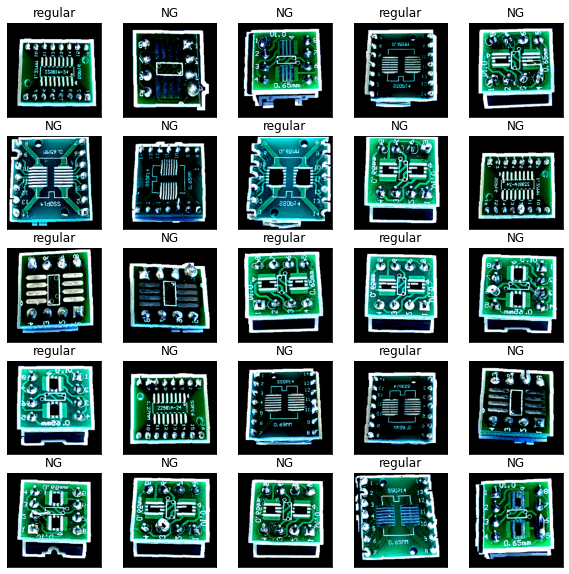

In [516]:

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1,2,0))) # チャンネルを一番後ろに
    label = img_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

In [517]:
# ミニバッチのサイズを指定
batch_size = 10

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader }

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([10, 3, 256, 256])
tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0])


In [518]:
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test' : len(test_dataset)
}

In [519]:
# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
# net = models.vgg16(pretrained=use_pretrained)
net = torchvision.models.resnet50(pretrained=True).to(device)

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [520]:

# VGG16の最後の出力層の出力ユニットを2カテゴリに付け替える
# net.classifier[6] = nn.Linear(in_features=4096, out_features=2)


# Resnet50の最後の出力層の出力ユニットを2カテゴリに付け替える
net.fc = nn.Linear(in_features=2048, out_features=2)

params_to_update = []
update_params_name = ['fc.weight', 'fc.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

fc.weight
fc.bias
ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [521]:
net = net.to(device)

In [522]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()


In [523]:
# # ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

# params_to_update_1 = []
# params_to_update_2 = []
# params_to_update_3 = []

# # 学習させる層のパラメータ名を指定
# update_param_names_1 = ["features"]
# update_param_names_2 = ["classifier.0.weight",
#                         "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
# update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# # パラメータごとに各リストに格納する
# for name, param in net.named_parameters():
#     if update_param_names_1[0] in name:
#         param.requires_grad = True
#         params_to_update_1.append(param)
#         print("params_to_update_1に格納：", name)

#     elif name in update_param_names_2:
#         param.requires_grad = True
#         params_to_update_2.append(param)
#         print("params_to_update_2に格納：", name)

#     elif name in update_param_names_3:
#         param.requires_grad = True
#         params_to_update_3.append(param)
#         print("params_to_update_3に格納：", name)

#     else:
#         param.requires_grad = False
#         print("勾配計算なし。学習しない：", name)


# # 転移学習で学習させるパラメータを、変数params_to_updateに格納する
# params_to_update = []

# # 学習させるパラメータ名
# update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
# for name, param in net.named_parameters():
#     if name in update_param_names:
#         param.requires_grad = True
#         params_to_update.append(param)
#         print(name)
#     else:
#         param.requires_grad = False

# # params_to_updateの中身を確認
# print("-----------")
# print(params_to_update)




In [524]:
# 最適化手法の設定
# optimizer = optim.SGD([
#     {'params': params_to_update_1, 'lr': 1e-4},
#     {'params': params_to_update_2, 'lr': 5e-4},
#     {'params': params_to_update_3, 'lr': 1e-3}
# ])

optimizer = optim.Adam(params=params_to_update)# , weight_decay=1e-4)

# # 最適化アルゴリズム
# optimizer = optim.Adam(net.parameters())

In [525]:
# モデルを学習させる関数を作成


# def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

#     # 初期設定
#     # GPUが使えるかを確認
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("使用デバイス：", device)

#     # ネットワークをGPUへ
#     net.to(device)

#     # ネットワークがある程度固定であれば、高速化させる
#     torch.backends.cudnn.benchmark = True

#     # epochのループ
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch+1, num_epochs))
#         print('-------------')

#         # epochごとの訓練と検証のループ
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 net.train()  # モデルを訓練モードに
#             else:
#                 net.eval()   # モデルを検証モードに

#             epoch_loss = 0.0  # epochの損失和
#             epoch_corrects = 0  # epochの正解数

#             # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
#             if (epoch == 0) and (phase == 'train'):
#                 continue

#             # データローダーからミニバッチを取り出すループ
#             for inputs, labels in tqdm(dataloaders_dict[phase]):

#                 # GPUが使えるならGPUにデータを送る
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # optimizerを初期化
#                 optimizer.zero_grad()

#                 # 順伝搬（forward）計算
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = net(inputs)
#                     loss = criterion(outputs, labels)  # 損失を計算
#                     _, preds = torch.max(outputs, 1)  # ラベルを予測

#                     # 訓練時はバックプロパゲーション
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                     # 結果の計算
#                     epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
#                     # 正解数の合計を更新
#                     epoch_corrects += torch.sum(preds == labels.data)

#             # epochごとのlossと正解率を表示
#             epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
#             epoch_acc = epoch_corrects.double(
#             ) / len(dataloaders_dict[phase].dataset)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

def train(model, dataloaders, otpimizer, criterion, num_epochs, device):
    """
    model:学習モデル
    dataloader:学習、評価データのdataloader
    optimizer:最適化関数
    crierion:ロス関数
    num_epochs:学習回数
    device:CPUかGPUか
    """
    best_acc = 0.0
    # 学習を繰り返す
    for epoch in range(num_epochs):
        # trainとvalを繰り返す
        for phase in ['train', 'val']:
            # モデルを学習モードか評価モードに切り替える
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 精度計算用
            loss_sum = 0.0
            acc_sum = 0.0
            total = 0

            # 進捗の表示
            with tqdm(total=len(dataloaders[phase]),unit="batch") as pbar:
                pbar.set_description(f"Epoch[{epoch}/{num_epochs}]({phase})")
                
                # dataloadersからバッチサイズに応じてデータを取得
                for inputs, labels in dataloaders[phase]:
                    # 画像とラベルをGPU/CPUか切り替え
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 予測
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # ロス算出
                    loss = criterion(outputs, labels)
                    
                    # 予測とラベルの差を使って学習 
                    if phase == 'train':
                        # ここは決まり文句
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # ロス、精度を算出
                    total += inputs.size(0)
                    loss_sum += loss.item() * inputs.size(0)
                    acc_sum += torch.sum(preds == labels.data).item()
                    
                    # 進捗の表示
                    pbar.set_postfix({"loss":loss_sum/float(total),"accuracy":float(acc_sum)/float(total)})
                    pbar.update(1)

            # 1エポックでのロス、精度を算出
            epoch_loss = loss_sum / dataset_sizes[phase]
            epoch_acc = acc_sum / dataset_sizes[phase]
            
            # 一番良い制度の時にモデルデータを保存
            if phase == 'val' and epoch_acc > best_acc:
                print(f"save model epoch:{epoch} loss:{epoch_loss} acc:{epoch_acc}")
                torch.save(model, 'best_model.pth')



In [526]:
# # 学習・検証を実行する
# num_epochs=3
# train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

num_epochs = 40
train(net, dataloaders_dict, optimizer, criterion, num_epochs, device)

Epoch[0/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.61batch/s, loss=0.637, accuracy=0.707]


save model epoch:0 loss:0.6369556774353159 acc:0.7068965517241379


Epoch[1/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.71batch/s, loss=0.718, accuracy=0.517]


save model epoch:1 loss:0.7180818596790577 acc:0.5172413793103449


Epoch[2/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.50batch/s, loss=0.526, accuracy=0.81]


save model epoch:2 loss:0.5255655821027427 acc:0.8103448275862069


Epoch[3/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.84batch/s, loss=0.49, accuracy=0.81]


save model epoch:3 loss:0.49008326283816633 acc:0.8103448275862069


Epoch[4/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.71batch/s, loss=0.483, accuracy=0.81]


save model epoch:4 loss:0.4826903312370695 acc:0.8103448275862069


Epoch[5/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.63batch/s, loss=0.442, accuracy=0.828]


save model epoch:5 loss:0.442443552716025 acc:0.8275862068965517


Epoch[6/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.45batch/s, loss=0.442, accuracy=0.828]


save model epoch:6 loss:0.4416269500707758 acc:0.8275862068965517


Epoch[7/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.62batch/s, loss=0.683, accuracy=0.517]


save model epoch:7 loss:0.683461354210459 acc:0.5172413793103449


Epoch[8/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.64batch/s, loss=0.426, accuracy=0.845]


save model epoch:8 loss:0.42578526303685943 acc:0.8448275862068966


Epoch[9/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.70batch/s, loss=0.465, accuracy=0.828]


save model epoch:9 loss:0.4646933489832385 acc:0.8275862068965517


Epoch[10/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.69batch/s, loss=0.423, accuracy=0.828]


save model epoch:10 loss:0.42277104433240564 acc:0.8275862068965517


Epoch[11/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.63batch/s, loss=0.416, accuracy=0.862]


save model epoch:11 loss:0.41573906355890733 acc:0.8620689655172413


Epoch[12/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.81batch/s, loss=0.431, accuracy=0.81]


save model epoch:12 loss:0.4307145157764698 acc:0.8103448275862069


Epoch[13/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.65batch/s, loss=0.442, accuracy=0.759]


save model epoch:13 loss:0.4415752199189416 acc:0.7586206896551724


Epoch[14/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.67batch/s, loss=0.381, accuracy=0.879]


save model epoch:14 loss:0.38116529429781026 acc:0.8793103448275862


Epoch[15/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.85batch/s, loss=0.375, accuracy=0.879]


save model epoch:15 loss:0.37465746597997074 acc:0.8793103448275862


Epoch[16/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.51batch/s, loss=0.374, accuracy=0.879]


save model epoch:16 loss:0.3738148222709524 acc:0.8793103448275862


Epoch[17/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.75batch/s, loss=0.4, accuracy=0.845]


save model epoch:17 loss:0.39990391607942255 acc:0.8448275862068966


Epoch[18/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.70batch/s, loss=0.383, accuracy=0.828]


save model epoch:18 loss:0.3830588660363493 acc:0.8275862068965517


Epoch[19/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.77batch/s, loss=0.41, accuracy=0.81]


save model epoch:19 loss:0.409634614042167 acc:0.8103448275862069


Epoch[20/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.63batch/s, loss=0.428, accuracy=0.776]


save model epoch:20 loss:0.4277017116546631 acc:0.7758620689655172


Epoch[21/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.60batch/s, loss=0.435, accuracy=0.776]


save model epoch:21 loss:0.43491429398799764 acc:0.7758620689655172


Epoch[22/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.53batch/s, loss=0.628, accuracy=0.603]


save model epoch:22 loss:0.6275005952037614 acc:0.603448275862069


Epoch[23/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.75batch/s, loss=0.391, accuracy=0.879]


save model epoch:23 loss:0.39066367211013003 acc:0.8793103448275862


Epoch[24/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.66batch/s, loss=0.369, accuracy=0.879]


save model epoch:24 loss:0.368594776453643 acc:0.8793103448275862


Epoch[25/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.67batch/s, loss=0.412, accuracy=0.81]


save model epoch:25 loss:0.4122092991039671 acc:0.8103448275862069


Epoch[26/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.63batch/s, loss=0.344, accuracy=0.914]


save model epoch:26 loss:0.34370969852496835 acc:0.9137931034482759


Epoch[27/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.69batch/s, loss=0.454, accuracy=0.741]


save model epoch:27 loss:0.4535098322506609 acc:0.7413793103448276


Epoch[28/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.63batch/s, loss=0.333, accuracy=0.897]


save model epoch:28 loss:0.333377285250302 acc:0.896551724137931


Epoch[29/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.57batch/s, loss=0.389, accuracy=0.793]


save model epoch:29 loss:0.38917831511333073 acc:0.7931034482758621


Epoch[30/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.57batch/s, loss=0.378, accuracy=0.879]


save model epoch:30 loss:0.37761868587855635 acc:0.8793103448275862


Epoch[31/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.53batch/s, loss=0.37, accuracy=0.828]


save model epoch:31 loss:0.3698125841288731 acc:0.8275862068965517


Epoch[32/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.54batch/s, loss=0.338, accuracy=0.879]


save model epoch:32 loss:0.3379338686836177 acc:0.8793103448275862


Epoch[33/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.53batch/s, loss=0.333, accuracy=0.879]


save model epoch:33 loss:0.33287315507387294 acc:0.8793103448275862


Epoch[34/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.47batch/s, loss=0.438, accuracy=0.724]


save model epoch:34 loss:0.4382028754415183 acc:0.7241379310344828


Epoch[35/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.63batch/s, loss=0.378, accuracy=0.845]


save model epoch:35 loss:0.3784633083590146 acc:0.8448275862068966


Epoch[36/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.58batch/s, loss=0.35, accuracy=0.879]


save model epoch:36 loss:0.349954167830533 acc:0.8793103448275862


Epoch[37/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.49batch/s, loss=0.332, accuracy=0.914]


save model epoch:37 loss:0.33214337455815285 acc:0.9137931034482759


Epoch[38/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.60batch/s, loss=0.315, accuracy=0.879]


save model epoch:38 loss:0.31519602547431813 acc:0.8793103448275862


Epoch[39/40](val): 100%|██████████| 6/6 [00:00<00:00,  7.39batch/s, loss=0.346, accuracy=0.879]


save model epoch:39 loss:0.34560593243302973 acc:0.8793103448275862


In [536]:
# # 今回学習したモデルでテスト
best_model = torch.load('best_model.pth')

In [537]:
# best_model.eval()

In [538]:
import copy
# from sklearn.metrics import classification_report
# netcpu = copy.deepcopy(net).to('cpu')
# pred = []
# Y = []
# for i, (x,y) in enumerate(test_dataloader):
#     with torch.no_grad():
#         output = netcpu(x)
#     pred += [int(l.argmax()) for l in output]
#     Y += [int(l) for l in y]

# print(classification_report(Y, pred))

In [539]:
# len(np.array(pred[1:]))

In [540]:
# テストデータから予測を作成する関数
netcpu = copy.deepcopy(best_model).to('cpu')

def pred_model(net, dataloaders_dict, criterion, optimizer):
  

  phase = 'test'
  net.eval()   # モデルを検証モードに

  # 提出データ作成用の入れ物を作成
  subT = torch.randn(1)

  # データローダーからミニバッチを取り出すループ
  for inputs, labels in tqdm(dataloaders_dict[phase]):
    # optimizerを初期化
    optimizer.zero_grad()
    #学習したモデルで、予測を実施
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)  # ラベルを予測
    #print(subT.shape,preds.shape)
    subT = torch.cat([subT,preds])
  #print(subT.shape)
  return subT

In [541]:
#　テストデータから予測の実行
sub = pred_model(netcpu, dataloaders_dict, criterion, optimizer)

100%|██████████| 22/22 [00:47<00:00,  2.17s/it]


In [542]:
#予測結果をCPU上のnumpy配列に変換
xnumpy = sub.to('cpu').detach().numpy().copy()

In [543]:
len(xnumpy[1:])


213

In [544]:
import pandas as pd 
sublabel = pd.DataFrame(xnumpy[1:]) #　予測値をデータフレームに格納
# sublabel = pd.DataFrame(np.array(pred[1:]))
sublabel.columns = ['sub'] #　列名を提出で指定されたsubにする
sublabel = sublabel.astype(int) # 予測値を整数（０か１）に変換

subdf = pd.DataFrame(test_list) # testデータのファイルリストを取得
filelist = subdf[0].str.split('/',expand=True) #　ファイル名だけ抽出

# ファイル名のリストと、予測値を結合
subfin = pd.concat([filelist,sublabel],axis=1).reset_index(drop=True)
sortedsub=subfin.sort_values(4) #　ファイル名順に並べ替え
lastsub = sortedsub[[4,'sub']] #　必要な列だけに絞り込み

#提出ファイルを保存
lastsub.to_csv('015-submit.tsv',header=False, index=False, sep='\t') 